In [1]:
%env THEANO_FLAGS=device=gpu1
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

env: THEANO_FLAGS=device=gpu1


# data

In [2]:
with open("./tokens.txt") as fin:
    tokens = filter(len,fin.read().split('\n'))
    
tokens.append("_BOS_") #beginning of sentence. Omitted in danet
tokens.append("_PAD_") #padding. Omitted in danet

UNK_ix,BOS_ix,EOS_ix,PAD_ix = map(tokens.index,["_UNK_","_BOS_","_EOS_","_PAD_"])
n_tokens = len(tokens)

from collections import defaultdict
token_to_ix = defaultdict(lambda:UNK_ix,{t:i for i,t in enumerate(tokens)})

In [3]:
import regex
def preprocess(lines,speaker=None,add_eos=True):
    if type(lines) in (str,unicode):
        lines = [lines]
    
    context=[]
    for line in lines:
        line = line.lower()
        line = regex.sub(ur'(\p{P}|`|~)', ur' \1 ', line)
        line_ix = map(token_to_ix.__getitem__,filter(len,line.split()))
        if add_eos:
            line_ix.append(EOS_ix)
        context += line_ix
            
    if speaker is not None:
        context.append(speaker)
        
    return context

def ix_to_matrix(phrases_ix,max_len = None,):
    max_len = max_len or max(map(len,phrases_ix))
    
    matrix = np.zeros((len(phrases_ix),max_len),dtype='int32') + PAD_ix
    
    for i,phrase_ix in enumerate(phrases_ix):
        matrix[i,:min(len(phrase_ix),max_len)] = phrase_ix[:max_len]
        
    return matrix

def phrase_to_matrix(contexts,max_len = None,**kwargs):
            
    return ix_to_matrix([preprocess(phrases,**kwargs) for phrases in contexts],max_len=max_len)



# model

In [4]:
from warnings import warn
import numpy as np
import theano
theano.config.floatX='float32'
import theano.tensor as T
import lasagne
from lasagne.layers import *



WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:558: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 1: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)


In [5]:


grad_clipping=5
lstm_units = 1024
emb_size=512


temperature = theano.shared(np.float32(1.))
semantic_space_size = 1024



In [6]:

from pretrained_network.wrong_lstm_layer import WrongLSTMLayer

class context2vec:
            
    l_in = InputLayer((None,None),name='context input')
    l_mask = ExpressionLayer(l_in,lambda x:T.neq(x,PAD_ix),name='context mask')
    
    l_emb = EmbeddingLayer(l_in,n_tokens,emb_size,name="context embedding")
    
    
    ####LSTMLayer with incorrect outputgate####
    
    l_lstm = WrongLSTMLayer(
                        l_emb,
                        lstm_units,
                        name='context_encoder_lstm',
                        grad_clipping=grad_clipping,
                        mask_input = l_mask,
                        only_return_final=True,
                        peepholes=False)
    
    output = DenseLayer(l_lstm,semantic_space_size,name="context_output",
                        nonlinearity=T.nnet.sigmoid)
    
    weights = get_all_params(output,trainable=True)

        
class answer2vec:
            
    l_in = InputLayer((None,None),name='answer input')
    l_mask = ExpressionLayer(l_in,lambda x:T.neq(x,PAD_ix),name='answer mask')
    
    l_emb = EmbeddingLayer(l_in,n_tokens,emb_size,W = context2vec.l_emb.W,
                           name="answer embedding")
    
    
    ####LSTMLayer with incorrect outputgate####
    
    l_lstm = WrongLSTMLayer(
                        l_emb,
                        lstm_units,
                        name='answer_encoder_lstm',
                        grad_clipping=grad_clipping,
                        mask_input = l_mask,
                        only_return_final=True,
                        peepholes=False)
    
    output = DenseLayer(l_lstm,semantic_space_size,name="answer=_output",
                        nonlinearity=T.nnet.sigmoid)
        
    
    weights = get_all_params(output,trainable=True)


        
        


        
        


In [7]:
from agentnet.utils.persistence import load
load(context2vec.l_lstm,"pretrained_network/encoder.pcl")
load(answer2vec.l_lstm,"pretrained_network/encoder.pcl")

In [8]:
get_norm = lambda v: (v**2).sum(axis=-1)**.5
get_cosine = lambda v1,v2: (v1*v2).sum(axis=-1) / (get_norm(v1)*get_norm(v2))

class dssm:
    context_ix  = T.imatrix("context tokens")
    good_answer_ix  = T.imatrix("good answer tokens")
    bad_answer_ix  = T.imatrix("bad answer tokens")
    delta = theano.shared(np.float32(0.5))
    
    v_context = get_output(context2vec.output,context_ix)
    v_good_answer = get_output(answer2vec.output,good_answer_ix)
    v_bad_answer = get_output(answer2vec.output,bad_answer_ix)
    
    assert v_context.ndim == v_good_answer.ndim == v_bad_answer.ndim == 2
    
    good_similarity = get_cosine(v_context,v_good_answer)
    bad_similarity = get_cosine(v_context,v_bad_answer)
    
    pairwise_hinge_loss = T.nnet.relu(bad_similarity - good_similarity + delta).mean()
    
    all_weights = list(set(context2vec.weights+answer2vec.weights))
    
    updates = lasagne.updates.adam(pairwise_hinge_loss,all_weights,learning_rate=1e-4)
    
    
    train_step = theano.function([context_ix,good_answer_ix,bad_answer_ix],pairwise_hinge_loss,
                                 updates=updates)
    
    evaluate = theano.function([context_ix,good_answer_ix,bad_answer_ix],pairwise_hinge_loss)
    
    score = theano.function([context_ix,good_answer_ix],good_similarity)
    


### training

In [9]:
from prefetch_generator import background
@background(max_prefetch=10)
def generate_data(data_rows,batch_size=32,context_length = 3,n_iter=np.inf):
    i=0
    while True:
        batch_ix = np.random.randint(0,len(data_rows)-context_length-1,batch_size)
        context_ix = batch_ix[:,None] + np.arange(context_length)[None,:]
        answer_ix = batch_ix + context_length
        batch_x = ix_to_matrix(map(np.concatenate,data_rows[context_ix]))
        batch_y = ix_to_matrix(data_rows[answer_ix])
        yield batch_x,batch_y
        i+=1
        if i>=n_iter:
            break



In [10]:
from tqdm import tqdm

with open("open_subtitles_en_raw") as fin:
    
    rows = map(lambda s: s.decode('utf-8'),fin.read().split('\n')[:-1])
    rows = map(preprocess,tqdm(rows))
    rows = np.array(map(np.array,rows))

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [20]:
loss_history = []
val_score_history = []

mean loss =  0.262894
mean val loss =  0.285154


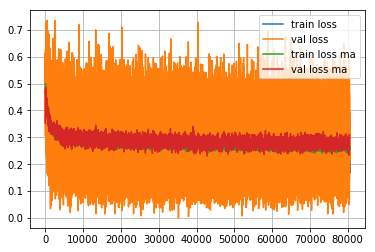

278it [00:37,  7.36it/s]

In [ ]:
from IPython.display import clear_output
from pandas import ewma
n_batches=100
rows_train = rows[:len(rows)*9/10]
rows_val = rows[len(rows)*9/10:]


while True:
    for i,(bx,by) in tqdm(enumerate(generate_data(rows_train,batch_size=64,n_iter=n_batches*5))):
        assert len(bx)%2==0
        half = len(bx)/2
        batch_context = bx[:half]
        batch_good_answer = by[:half]
        batch_bad_answer = by[half:]

        loss=dssm.train_step(batch_context,batch_good_answer,batch_bad_answer)
        if i%5==0:
            loss_history.append(loss)
    
    for i,(bx,by) in tqdm(enumerate(generate_data(rows_val,batch_size=16,n_iter=n_batches))):
        assert len(bx)%2==0
        half = len(bx)/2
        batch_context = bx[:half]
        batch_good_answer = by[:half]
        batch_bad_answer = by[half:]

        val_score_history.append(dssm.evaluate(batch_context,batch_good_answer,batch_bad_answer))
    
    
    clear_output(True)
    plt.plot(loss_history,label='train loss')
    plt.plot(val_score_history,label='val loss')
    plt.plot(ewma(np.array(loss_history),span=50),label='train loss ma')
    plt.plot(ewma(np.array(val_score_history),span=50),label='val loss ma')
    print "mean loss = ",np.mean(loss_history[-n_batches:])
    print "mean val loss = ",np.mean(val_score_history[-n_batches:])
    
    plt.grid()
    plt.legend()
    plt.show()
    


In [14]:
from agentnet.utils.persistence import save
save([context2vec.output,answer2vec.output],"pretrained_network/dssm_simple.pcl")

In [ ]:
dssm.score(bx,by) - dssm.score(bx,by[::-1])

In [ ]:
dssm.score(bx,by)